In [2]:
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
#!pip install autogluon --no-cache-dir
#!pip install kaggle
#!pip install python-dotenv
!pip install missingno

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [18]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
%matplotlib inline

# Account/s3 setup


In [23]:

session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = "sagemaker/autogluon-tabular"
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
)

## Read Data

In [4]:
df = pd.read_csv('diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Get column names

In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## EDA

In [7]:
df.shape

(768, 9)

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### The results of this summary of describe function.
There are some value of below listed columns have zero minimum, the value of zero does indicates missing value.

Following columns or variables have an invalid zero value:

 - Glucose
 - BloodPressure
 - SkinThickness
 - Insulin
 - BMI

These missing values can be replaced by nan this will help in counting.

## Ploting Data Distribution

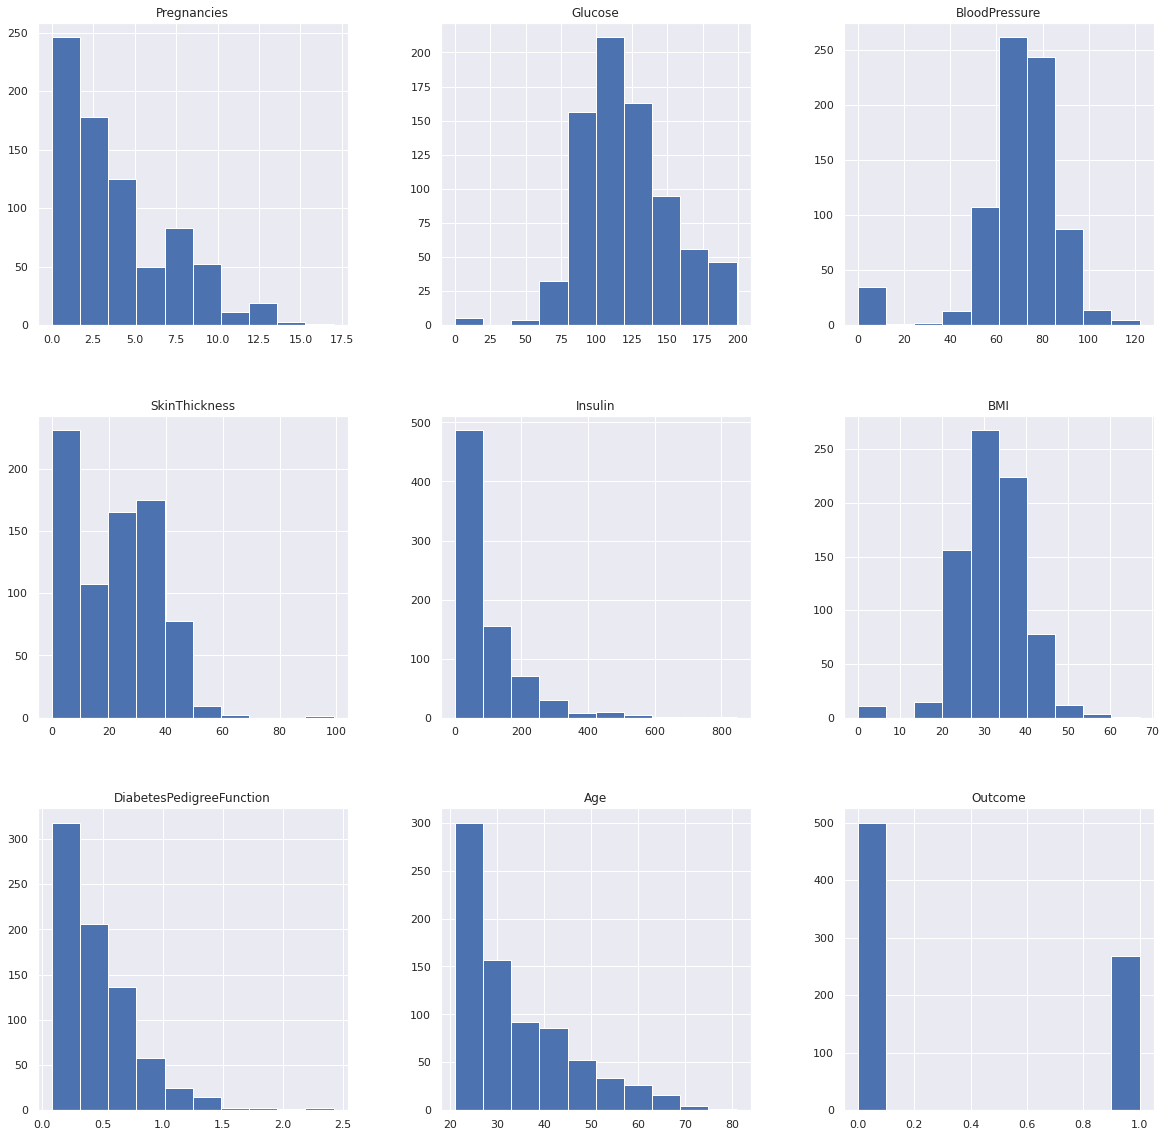

In [10]:
plot= df.hist(figsize = (20,20))

In [11]:
df_copy = df.copy(deep = True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Replacing nan values for the columns in accordance with their distribution


In [12]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)



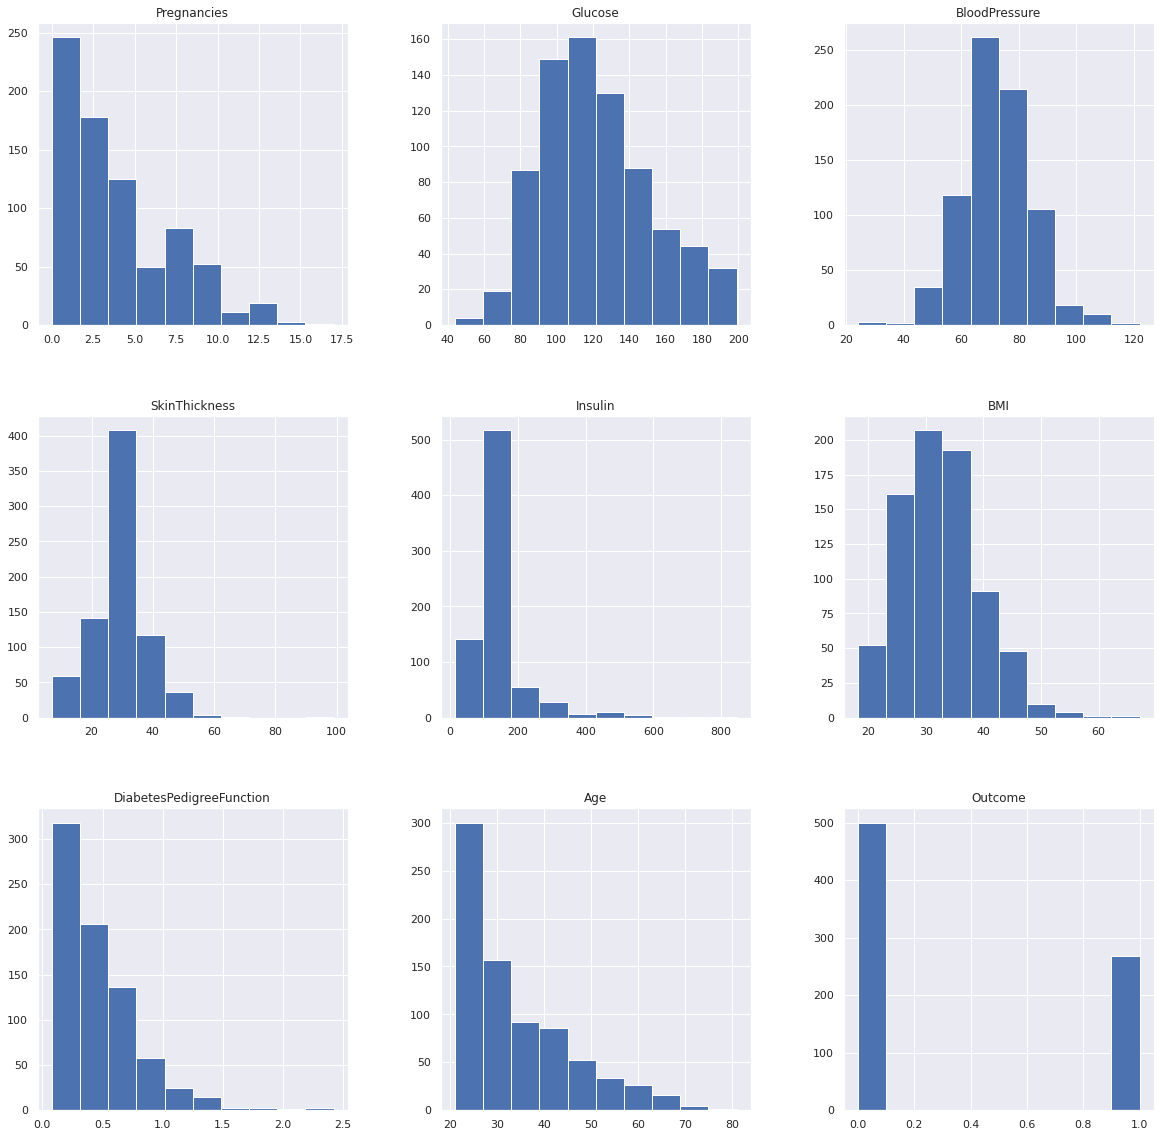

In [13]:
_=df_copy.hist(figsize =(20,20))

## null count analysis



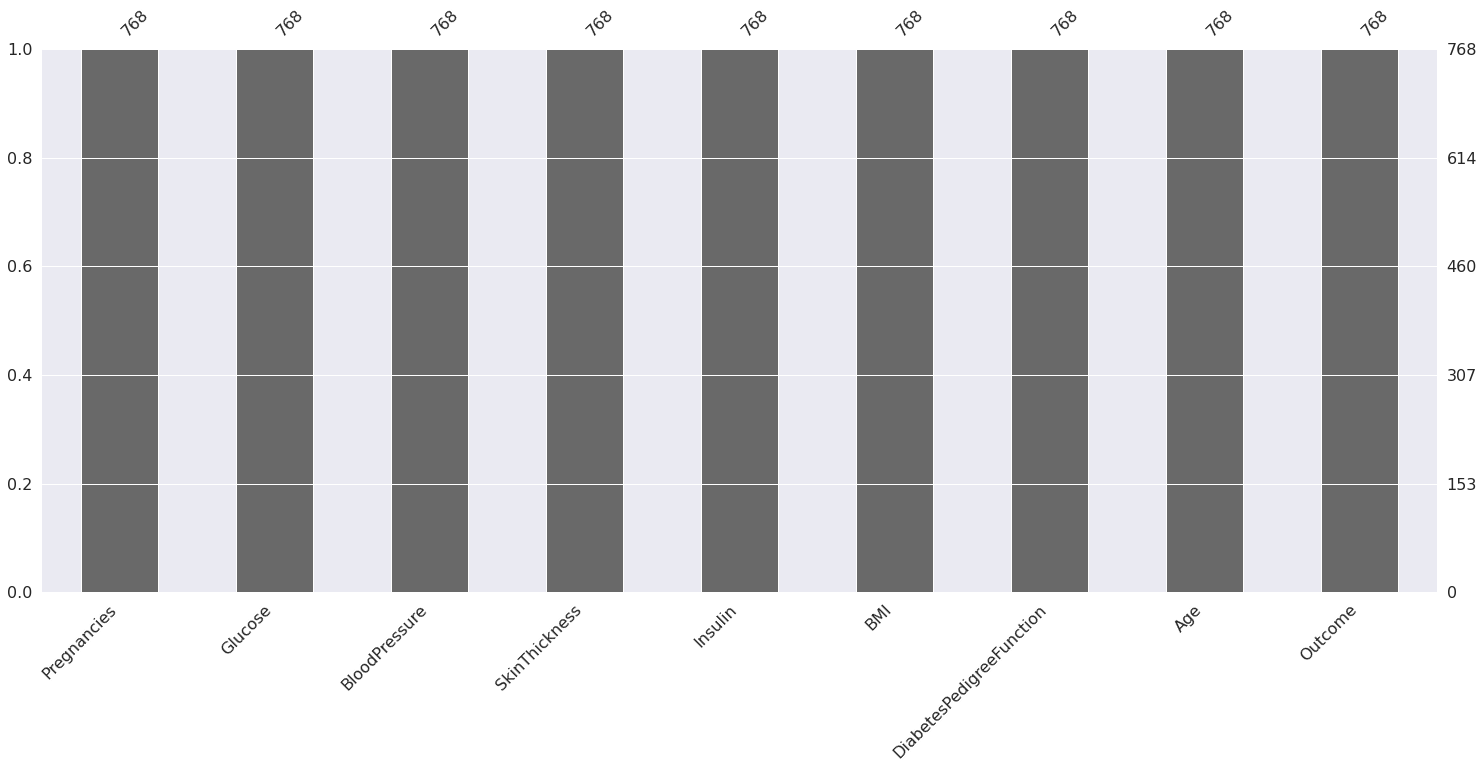

In [14]:
p=msno.bar(df)

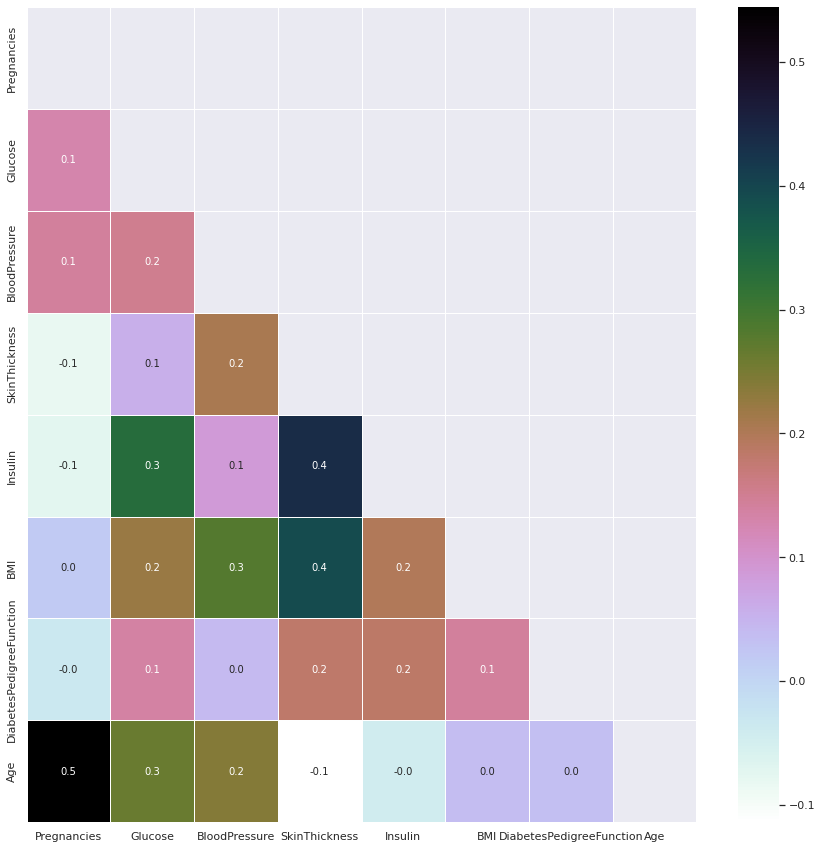

In [15]:
# Correlation visualisation
# Heatmap is good method to visualize correlation between features.
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
f,ax = plt.subplots(figsize=(15,15))
matrix = np.triu(df[cols].corr())
sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, fmt='.1f',mask=matrix, ax=ax,cmap='cubehelix_r')
plt.savefig('Corr.jpg')

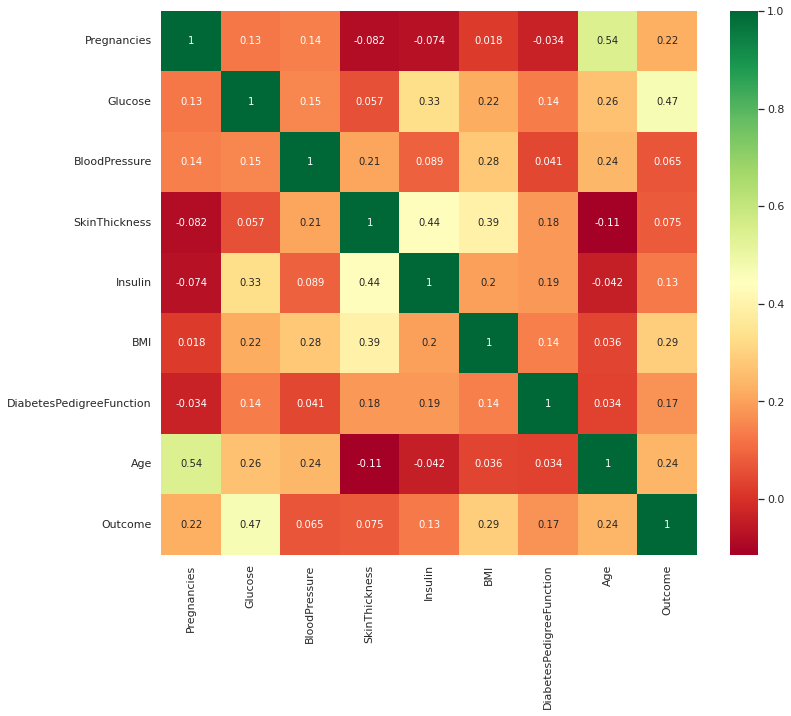

In [16]:
plt.figure(figsize=(12,10)) 
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')

# Split train/test data

In [17]:

train = df.sample(frac=0.7, random_state=42)
test = df.drop(train.index)


In [20]:
train.head(3)
train.shape



(538, 9)

In [21]:
test.head(3)
test.shape

(230, 9)

# Model Training

## Upload data to S3

In [24]:
train_file = "train.csv"
train.to_csv(train_file, index=False)
train_s3_path = session.upload_data(train_file, key_prefix="{}/data".format(prefix))

test_file = "test.csv"
test.to_csv(test_file, index=False)
test_s3_path = session.upload_data(test_file, key_prefix="{}/data".format(prefix))